In [2]:
#**** Code modified from example provided in module 3, Sentiment Analysis, in Coursera course:
# https://www.coursera.org/learn/python-text-mining/home/week/3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
import scipy 


In [3]:
my_data = pd.read_csv('C:\\Users\\renee\\Desktop\\DSBA\\Fall 2017\\DSBA - Applied Machine Learning\\GroupProject\\ReviewDataAll.csv')
                      #parse_dates=True

In [4]:
my_data.head(5)
print(my_data.shape)

(282600, 10)


In [5]:
#******************************************************************************************
#                      CREATE A BASELINE WORD SET OF POSITIVE AND NEGATIVE WORDS
#                      USING TFIDFVECTORIZE ON THE ENTIRE SET OF REVIEW WORDS
#********************************************************************************************

my_data.dropna(inplace=True)
baseline_data = my_data[my_data['stars'] != 3]  #assume 3 is a neutral rating (not positive or negative)
baseline_data['Positively Rated'] = np.where(baseline_data['stars'] > 3, 1, 0)

C:\Users\renee\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
print(my_data.shape)

(282600, 10)


In [7]:
baseline_data['Positively Rated'].mean()
baseline_data.shape

(246587, 11)

In [8]:
#separate out the review text data as the independent variables
# and the Positively rated flag as the target variable

x_train = baseline_data['text']
y_train = baseline_data['Positively Rated']
                            

In [9]:
#print('x_train shape:', x_train.shape)
#print('y train shape:', y_train.shape)

In [10]:
#regex examples from https://stackoverflow.com/questions/45547568/how-can-i-prevent-tfidfvectorizer-to-get-numbers-as-vocabulary

#vectorize the review texts, turning all non-numeric tokens into terms. 
# create a set of 1 to 3 n-gram words to take into account negative 
#phrases such as "did not like"

from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vect = TfidfVectorizer(min_df=5,  token_pattern='\w*[a-zA-Z]', stop_words='english', ngram_range=(1,3))
tfidf_vect = tfidf_vect.fit(x_train)
#len(tfidf_vect.get_feature_names())


In [11]:
#transform the terms into document term matrix and apply a logistic regression to 
# predict whether term is positive or negative 

x_train_tfidf_vect = tfidf_vect.transform(x_train)

clf_tfidf = lm.LogisticRegression()
clf_tfidf.fit(x_train_tfidf_vect, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
#sort the coefficients of the regression from smallest to largest 
tfidf_feature_names = np.array(tfidf_vect.get_feature_names())

sorted_coef_index = clf_tfidf.coef_[0].argsort()

# retrieve the terms with the smallest coefficients as the negatively associated words
# and the terms with the largest coefficients as the positively associated words. 
# this data set will be our baseline bag of words for the analysis of each business
tfidf_bad_review_words = tfidf_feature_names[sorted_coef_index[:2000]]
tfidf_good_review_words = tfidf_feature_names[sorted_coef_index[:-2001:-1]]


#print a sample of the positive and negative words for review
print('Smallest Coefs:\n{}\n' .format(tfidf_feature_names[sorted_coef_index[:1000]]))
print('Largest Coefs:\n{}\n' .format(tfidf_feature_names[sorted_coef_index[:-1001:-1]]))

Smallest Coefs:
[u'worst' u'bland' u'horrible' u'terrible' u'rude' u'mediocre'
 u'disappointing' u'poor' u'awful' u'overpriced' u'disappointed' u'ok'
 u'told' u'dry' u'meh' u'worse' u'cold' u'disgusting' u'money'
 u'unfortunately' u'tasteless' u'dirty' u'slow' u'disappointment' u'okay'
 u'sorry' u'waste' u'left' u'gross' u'asked' u'bad' u'unprofessional'
 u'stale' u'flavorless' u'lack' u'poorly' u'soggy' u'tasted' u'average'
 u'sad' u'tasted like' u'maybe' u'ridiculous' u'shame' u'barely' u'paid'
 u'lacking' u'management' u'charged' u'guess' u'zero' u'said' u'customers'
 u'ordered' u'salty' u'paying' u'better' u'lacked' u'avoid' u'greasy'
 u'overcooked' u'subpar' u'nasty' u'won t' u'sucks' u'attitude'
 u'undercooked' u'minutes' u'waited' u'pay' u'joke' u'burnt' u'ruined'
 u'unacceptable' u'frozen' u'beware' u'sick' u'mess' u'edible' u'supposed'
 u'manager' u'sadly' u'hoping' u'refused' u'downhill' u'completely'
 u'potential' u'ignored' u'par' u'yuck' u'fine' u't great' u'watery'
 u'ine

In [13]:
#**************************************************************************************************
#                               FIND THE 50 MOST POSITIVE AND NEGATIVE WORDS FOR EACH BUSINESS
#                               AND COUNT THE NUMBER OF THOSE WORDS THAT ARE IN THE BASELINE
#                               POSITIVE AND NEGATIVE WORD LISTS
#**************************************************************************************************

#apply same classification principles as above except this uses a mutlinomial logistic regression 
# to predict the actual star rating rather than a postiive or negative word association

# this also groups the analysis by each business to return the most and least positive words 
# per business 

def tfidf_analysis_(x_data, y_data, business_id):  
    ignored_df = list()
    if min(y_data) != max(y_data):
        tfidf_vect = TfidfVectorizer(token_pattern='\w*[a-zA-Z]', stop_words='english', ngram_range=(1,3))
        tfidf_vect = tfidf_vect.fit(x_data)
        x_train_tfidf_vect = tfidf_vect.transform(x_train)
        clf_tfidf = lm.LogisticRegression(multi_class='multinomial', solver='newton-cg')
        clf_tfidf.fit(x_train_tfidf_vect, y_train)
        
        tfidf_feature_names = np.array(tfidf_vect.get_feature_names())

        sorted_coef_index = clf_tfidf.coef_[0].argsort()

       # print('Smallest Coefs:\n{}\n' .format(tfidf_feature_names[sorted_coef_index[:5]]))
        #print('Largest Coefs:\n{}\n' .format(tfidf_feature_names[sorted_coef_index[:-6:-1]]))
        
        #print(feature_names[sorted_coef_index])
        worst = tfidf_feature_names[sorted_coef_index[:50]]
        best = tfidf_feature_names[sorted_coef_index[:-51:-1]]    

        return(business_id, worst, best)
    else:
        ignored_df.append(x_data)

In [20]:

#https://stackoverflow.com/questions/13907949/typeerror-nonetype-object-has-no-attribute-getitem

review_counts = pd.DataFrame(columns = ["name", "count_bad", "count_good", "stars"])
review_data = pd.DataFrame(columns = ["name", "count_bad", "count_good", "stars"])

# create separate train sets for each individual business to be sent to the classifier
for business_id, grp in my_data.groupby(["business_id"]):
    
    x_train = grp.text
    y_train = grp.stars
    business_id = business_id
   
    returns = tfidf_analysis_(x_train, y_train, business_id)
    
    if returns is not None:
   # count the number of good and bad words returned for each business that are also in the baseline list
        count_bad = 0
        count_good = 0
                
        for i in returns[1]: 
        
           # print(i)
            if i in tfidf_bad_review_words: 
                count_bad = count_bad + 1
                #print(count_bad)
                
        for i in returns[2]:
        
            #print(i)
            if i in tfidf_good_review_words:
                count_good = count_good + 1
                #print(count_good)
             
        review_data = pd.DataFrame([[returns[0], count_bad, count_good, np.mean(grp.stars)]], columns= ["name", "count_bad", "count_good", "stars"])
    review_counts = review_counts.append(review_data)
      

In [21]:
data = review_counts.loc[review_counts['count_bad'] != 0 ]
                         
for business_id in data: 
        data["ratio"] = data["count_good"]/data["count_bad"]

C:\Users\renee\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [22]:
print(data)

                      name count_bad count_good     stars     ratio
0   --7zmmkVg-IMGaXbuVd0SQ         6          3  3.904762       0.5
0   --EX4rRznJrltyn-34Jz1w         5          4  4.000000       0.8
0   --KCl2FvVQpvjzmZSPyviA         7          3  2.916667  0.428571
0   --U98MNlDym2cLn36BBPgQ        11          3  2.750000  0.272727
0   --cZ6Hhc9F7VkKXxHMVZSQ         2          2  3.913333         1
0   --j-kaNMCo1-DYzddCsA5Q        11         14  3.666667   1.27273
0   --j-kaNMCo1-DYzddCsA5Q        11         14  3.666667   1.27273
0   -0QtTRrAMn6DKLZNef3Ojg         8          4  2.333333       0.5
0   -2HjuT4yjLZ3b5f_abD87Q         8          2  3.375000      0.25
0   -2pQf1ceDZyE2ReCNbj-3A         8          3  3.440000     0.375
0   -2pmn-oTJeybmDrL-ojwrw        11          2  4.166667  0.181818
0   -2uUrtgM5fiOaCpQEnPv0g        10          0  2.750000         0
0   -33_OPx1aKM22qxioPgJ_Q         5          2  3.000000       0.4
0   -4cA4Kt0UKzGYimrZsYuQg         3          4 

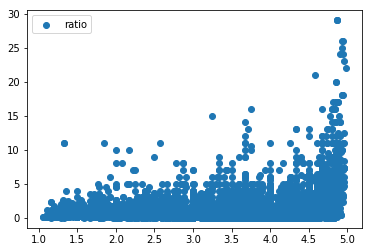

In [23]:
plt.scatter(data["stars"],data["ratio"])
    
plt.legend()
plt.show()

In [24]:
 print(review_counts.head(20))

                     name count_bad count_good     stars
0  --7zmmkVg-IMGaXbuVd0SQ         6          3  3.904762
0  --EX4rRznJrltyn-34Jz1w         5          4  4.000000
0  --KCl2FvVQpvjzmZSPyviA         7          3  2.916667
0  --U98MNlDym2cLn36BBPgQ        11          3  2.750000
0  --cZ6Hhc9F7VkKXxHMVZSQ         2          2  3.913333
0  --j-kaNMCo1-DYzddCsA5Q        11         14  3.666667
0  --j-kaNMCo1-DYzddCsA5Q        11         14  3.666667
0  -0QtTRrAMn6DKLZNef3Ojg         8          4  2.333333
0  -2HjuT4yjLZ3b5f_abD87Q         8          2  3.375000
0  -2pQf1ceDZyE2ReCNbj-3A         8          3  3.440000
0  -2pmn-oTJeybmDrL-ojwrw        11          2  4.166667
0  -2uUrtgM5fiOaCpQEnPv0g        10          0  2.750000
0  -33_OPx1aKM22qxioPgJ_Q         5          2  3.000000
0  -4cA4Kt0UKzGYimrZsYuQg         3          4  2.666667
0  -5FndHRwNg-xhPsctrhTbA         3          1  2.875000
0  -5KBZ3UmQzW_PkrjHGMuUg        13          3  2.850000
0  -5L8zOxibac-vBrsYtxXbQ      

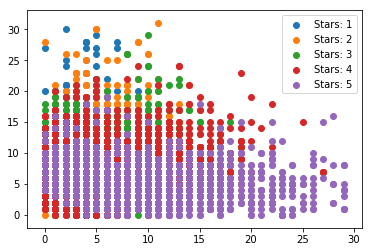

In [25]:
#https://stackoverflow.com/questions/16006572/plotting-different-colors-in-matplotlib

#plot the count of good words against bad words to estimate if the star rating matches the review sentiment
#color represents the star rating 
K= 5
review_counts['stars'] = np.round(review_counts['stars'])

for i in range(K):
    label = i + 1
      # select only data observations with cluster label == i

    data = review_counts.loc[review_counts['stars'] ==(i+1)]
    # plot the data observations
    #print(data)
 
    plt.scatter(data["count_good"],data["count_bad"], label='Stars: {label}'.format(label=label))

plt.xlabel = "Count of Good Words"
plt.ylabel = "Count of Bad Words"    
plt.legend()
plt.show()